## Notebook Overview:
The notebook is a continuation of my overall goal in providing personalized recommendations for travelers based on their preferences and past travel history. Includes steps for data overview, wrangling, and data exportation. I perform extensive data manipulation tasks such as dimensionality reduction and filtering to refine the data for more accurate recommendations. The final goal of the notebook is to export transformed data for modeling.

# Table of Contents

- [Introduction](#introduction)
- [Setup](#setup)
- [Data Wrangling](#data-wrangling)
  - [Data Reduction](#data-reduction)
    - [Cities](#cities)
    - [Categories](#categories)
        - [Acceptable Categories](#acceptable-categories)
        - [Removing unwanted subcategories and mislabled businesses](#removing-unwanted-subcategories-and-mislabled-businesses)
    - [Places To Eat](#places-to-eat)
      - [Restaurants](#restaurants)
    - [Things to Do](#things-to-do)
      - [Active Life](#active-life)
      - [Tours](#tours)
      - [Arts & Entertainment](#arts-&-entertainment)
      - [Combining Things To Do Data Frames](#combining-things-to-do-data-frames)
      - [Filtering Reviews](#filtering-reviews)
- [Exporting Data](#exporting-data)
      - [Ratings](#ratings)
      - [Business Data](#business-data)
      - [User Data](#user-data)



# Setup

Let's get started by importing the required packages and loading our data. 

In [18]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Loading Cleaned Data Sets
Be sure to run previous notebook and verify location of data files they should be located here: ~/BrainStation-Capstone/Data/cleaned_data_sets </br>
#### Business Data
| COLUMN NAME   | DESCRIPTION                                    | DATA TYPE   |
|---------------|------------------------------------------------|-------------|
| `business_id` | 22 character unique string business id         | string      |
| `name`        | The business's name                            | string      |
| `address`     | The full address of the business               | string      |
| `city`        | The city                                       | string      |
| `state`       | 2 character state code, if applicable          | string      |
| `postal_code` | The postal code                                | string      |
| `latitude`    | Latitude                                       | float       |
| `longitude`   | Longitude                                      | float       |
| `stars`       | Star rating(1-5), rounded to half-stars        | float       |
| `review_count`| Number of reviews                              | int         |
| `is_open`     | 0 or 1 for closed or open, respectively        | int         |
| `categories`  | Array of strings of business categories        | list        |
| `hours`       | Key day to value hours, hours are using a 24hr clock | dict  | 

</br>

#### User Data
| COLUMN NAME               | DESCRIPTION                                                        | DATA TYPE |
|---------------------------|--------------------------------------------------------------------|-----------|
| `user_id`                   | Unique user ID                                                     | string    |
| `name`                      | The user's first name                                              | string    |
| `review_count`              | Number of reviews written by the user                              | integer   |
| `average_stars`             | Average rating of all reviews                                      | float     |

</br>

#### Review Data
| COLUMN NAME  | DESCRIPTION                                                   | DATA TYPE |
|--------------|---------------------------------------------------------------|-----------|
| `review_id`  | Unique identifier for each review (22 character string)       | string    |
| `user_id`    | Unique identifier for each user (22 character string)         | string    |
| `business_id`| Unique identifier for businesses (22 character string)        | string    |
| `stars`      | Star rating given to the business (integer)                   | int       |
| `date`       | Date formatted YYYY-MM-DD                                     | string    |

In [13]:
# Reading parquet files into notebook and saving them to pandas df
df_b = pd.read_parquet ('../Data/cleaned_data_sets/dataset_business.parquet', engine='fastparquet')
df_u = pd.read_parquet ('../Data/cleaned_data_sets/dataset_user.parquet', engine='fastparquet')
df_r = pd.read_parquet ('../Data/cleaned_data_sets/dataset_review.parquet', engine='fastparquet')

# Data Wrangling 

Now that I've explored my data sets I need to do a little data wrangling before I can model user recommondations. Our model will need a ratings table with three features for each business rating: User Ids, Business Ids, and the rating given.

## Data Reduction
To improve computational speeds for modeling, I'll be reducing our original data set. 

### Cities
Only going to include three cities and Philidelphia, Nashville, and New Orleans, they seemed like the most fun to work with. 

In [14]:
df_b['city'].value_counts().head(6)

city
Philadelphia    14560
Tucson           9244
Tampa            9042
Indianapolis     7537
Nashville        6969
New Orleans      6208
Name: count, dtype: int64

In [15]:
# List of cities to include
cities_to_include = ["Philadelphia", "Nashville", "New Orleans"]

# Filter the DataFrame to only include rows with cities in the cities_to_include list
filtered_df_b = df_b[df_b['city'].isin(cities_to_include)]

In [16]:
filtered_df_b['city'].value_counts()

city
Philadelphia    14560
Nashville        6969
New Orleans      6208
Name: count, dtype: int64

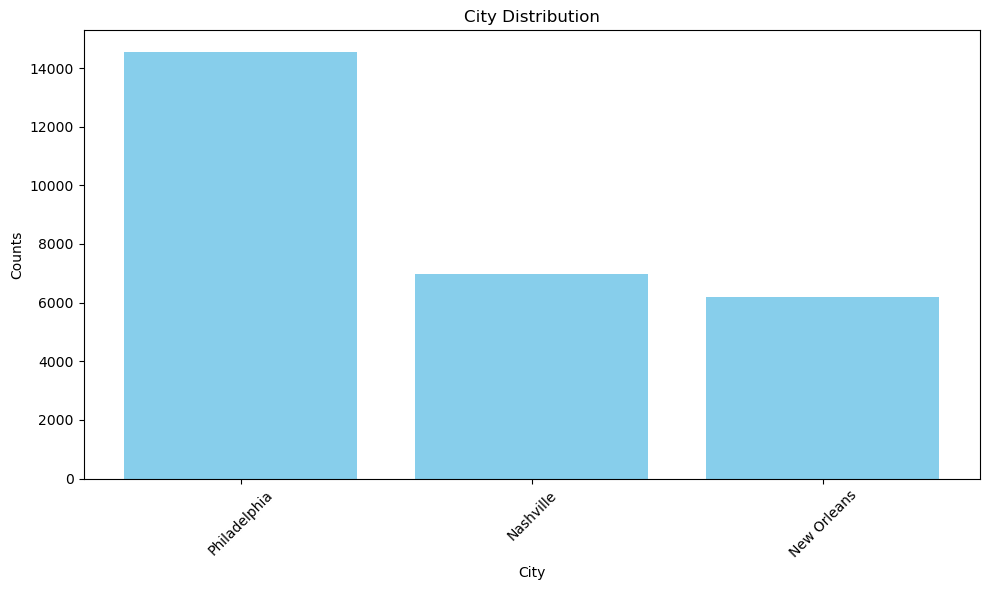

In [19]:
cities = ['Philadelphia', 'Nashville', 'New Orleans']
values = [14560, 6969, 6208]

# Create a bar chart
plt.figure(figsize=(10,6))
plt.bar(cities, values, color='skyblue')
plt.title('City Distribution')
plt.xlabel('City')
plt.ylabel('Counts')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
# plt.savefig('figures/BusinessCitiesChart.png', bbox_inches='tight')
# Show the plot
plt.show()

### Categories

I want to save each of these main categories to their own data frame. This will make the data easier to work with and segment my process working with one category at a time. 

In [20]:
# Saving separated data to their own data frames

restaurants_df = filtered_df_b[filtered_df_b['categories'].str.contains('Restaurants')].reset_index(drop=True)
food_df = filtered_df_b[filtered_df_b['categories'].str.contains(', Food,')].reset_index(drop=True)
active_life_df = filtered_df_b[filtered_df_b['categories'].str.contains('Active Life')].reset_index(drop=True)
arts_entertainment_df = filtered_df_b[filtered_df_b['categories'].str.contains('Arts & Entertainment')].reset_index(drop=True)
hotels_travel_df = filtered_df_b[filtered_df_b['categories'].str.contains('Hotels & Travel')].reset_index(drop=True)
nightlife_df = filtered_df_b[filtered_df_b['categories'].str.contains('Nightlife')].reset_index(drop=True)

print(f'Restaurants: {restaurants_df.shape}\n\
Food: {food_df.shape}\n\
Active Life: {active_life_df.shape}\n\
Arts & Entertainment: {arts_entertainment_df.shape}\n\
Hotels & Travel: {hotels_travel_df.shape}\n\
Nightlife: {nightlife_df.shape}')

Restaurants: (10613, 13)
Food: (3031, 13)
Active Life: (1283, 13)
Arts & Entertainment: (1517, 13)
Hotels & Travel: (1472, 13)
Nightlife: (3269, 13)


##### Acceptable Categories
I needed to create lists of acceptable categories so that I can check that each business is in one of the appropriate data frames that I just created. 

In [21]:
restaurants_categories = [
    "Restaurants", "Afghan", "African", "Senegalese", "South African", "American (New)", "American (Traditional)", "Andalusian", "Arabian", 
    "Arab Pizza", "Argentine", "Armenian", "Asian Fusion", "Asturian", "Australian", "Austrian", "Baguettes", "Bangladeshi", "Barbeque", "Basque", "Bavarian", "Beer Garden", "Beer Hall", "Beisl", "Belgian", 
    "Flemish", "Bistros", "Black Sea", "Brasseries", "Brazilian", "Brazilian Empanadas", "Central Brazilian", "Northeastern Brazilian", 
    "Northern Brazilian", "Rodizios", "Breakfast & Brunch", "Pancakes", "British", "Buffets", "Bulgarian", "Burgers", "Burmese", "Cafes", 
    "Themed Cafes", "Cafeteria", "Cajun/Creole", "Cambodian", "Canadian (New)", "Canteen", "Caribbean", "Dominican", "Haitian", "Puerto Rican", 
    "Trinidadian", "Catalan", "Cheesesteaks", "Chicken Shop", "Chicken Wings",  "Chilean", "Chinese", "Cantonese", "Congee", "Dim Sum", "Fuzhou", 
    "Hainan", "Hakka", "Henghwa", "Hokkien", "Hunan", "Pekinese", "Shanghainese", "Szechuan", "Teochew", "Comfort Food", "Corsican", 
    "Creperies", "Cuban", "Curry Sausage", "Cypriot", "Czech", "Czech/Slovakian", "Danish", "Delis", "Diners", "Dinner Theater", "Dumplings", 
    "Eastern European", "Eritrean", "Ethiopian", "Fast Food", "Filipino", "Fischbroetchen", "Fish & Chips", "Flatbread", "Fondue", "Food Court", 
    "Food Stands", "Freiduria", "French", "Alsatian", "Auvergnat", "Berrichon", "Bourguignon", "Mauritius", "Nicoise", "Provencal", "Reunion", "French Southwest", 
    "Galician", "Game Meat", "Gastropubs", "Georgian", "German", "Baden", "Eastern German", "Franconian", "Hessian", "Northern German", "Palatine", 
    "Rhinelandian", "Giblets", "Gluten-Free", "Greek", "Guamanian", "Halal", "Hawaiian", "Heuriger", "Himalayan/Nepalese", "Honduran", "Hong Kong Style Cafe", 
    "Hot Dogs", "Hot Pot", "Hungarian", "Iberian", "Indian", "Indonesian", "International", "Irish", "Island Pub", "Israeli", "Italian", "Abruzzese", 
    "Altoatesine", "Apulian", "Calabrian", "Cucina Campana", "Emilian", "Friulan", "Ligurian", "Lumbard", "Napoletana", "Piemonte", "Roman", "Sardinian", 
    "Sicilian", "Tuscan", "Venetian", "Japanese", "Blowfish", "Conveyor Belt Sushi", "Donburi", "Gyudon", "Oyakodon", "Hand Rolls", "Horumon", "Izakaya", 
    "Japanese Curry", "Kaiseki", "Kushikatsu", "Oden", "Okinawan", "Okonomiyaki", "Onigiri", "Ramen", "Robatayaki", "Soba", "Sukiyaki", "Takoyaki", 
    "Tempura", "Teppanyaki", "Tonkatsu", "Udon", "Unagi", "Western Style Japanese Food", "Yakiniku", "Yakitori", "Jewish", "Kebab", "Kopitiam", "Korean", "Kosher", 
    "Kurdish", "Laos", "Laotian","Latin American","Colombian","Salvadoran","Venezuelan","Live/Raw Food","Lyonnais","Malaysian","Mamak","Nyonya","Meatballs",
    "Mediterranean","Falafel","Mexican","Eastern Mexican","Jaliscan","Northern Mexican","Oaxacan","Pueblan","Tacos","Tamales","Yucatan","Middle Eastern",
    "Egyptian","Lebanese","Milk Bars","Modern Australian","Modern European","Mongolian","Moroccan","New Mexican Cuisine","New Zealand","Nicaraguan",
    "Night Food","Nikkei","Noodles","Norcinerie","Open Sandwiches","Oriental","Pakistani","Pan Asian","Parent Cafes","Parma","Persian/Iranian","Peruvian",
    "PF/Comercial","Pita","Pizza","Polish","Pierogis","Polynesian","Pop-Up Restaurants","Portuguese","Alentejo","Algarve","Azores","Beira","Fado Houses","Madeira",
    "Minho","Ribatejo","Tras-os-Montes","Potatoes","Poutineries","Pub Food","Rice","Romanian","Rotisserie Chicken","Russian","Salad","Sandwiches","Scandinavian",
    "Schnitzel","Scottish","Seafood","Serbo Croatian","Signature Cuisine","Singaporean","Slovakian","Somali","Soul Food","Soup","Southern","Spanish","Arroceria/Paella",
    "Sri Lankan","Steakhouses","Supper Clubs","Sushi Bars","Swabian","Swedish","Swiss Food","Syrian","Tabernas","Taiwanese","Tapas Bars","Tapas/Small Plates","Tavola Calda",
    "Tex-Mex","Thai","Traditional Norwegian","Traditional Swedish","Trattorie","Turkish","Chee Kufta","Gozleme","Homemade Food","Lahmacun","Ottoman Cuisine",
    "Turkish Ravioli","Ukrainian","Uzbek","Vegan","Vegetarian","Venison","Vietnamese","Waffles","Wok","Wraps","Yugoslav"
]


In [22]:
al_categories = [
    "Active Life",
    "Amusement Parks",
    "Aquariums",
    "Archery",
    "ATV Rentals/Tours",
    "Axe Throwing",
    "Bathing Area",
    "Beach Equipment Rentals",
    "Beach Volleyball",
    "Beaches",
    "Bicycle Paths",
    "Bike Parking",
    "Bike Rentals",
    "Boating",
    "Bungee Jumping",
    "Canyoneering",
    "Carousels",
    "Climbing",
    "Scuba Diving",
    "Escape Games",
    "Experiences",
    "Yoga",
    "Flyboarding",
    "Gliding",
    "Go Karts",
    "Golf",
    "Hang Gliding",
    "Hiking",
    "Horse Racing",
    "Horseback Riding",
    "Hot Air Balloons",
    "Jet Skis",
    "Kids Activities",
    "Kiteboarding",
    "Lakes",
    "Mini Golf",
    "Mountain Biking",
    "Paddleboarding",
    "Paragliding",
    "Parasailing",
    "Parks",
    "Dog Parks",
    "Skate Parks",
    "Public Plazas",
    "Racing Experience",
    "Rafting/Kayaking",
    "Recreation Centers",
    "Rock Climbing",
    "Sailing",
    "Scavenger Hunts",
    "Scooter Rentals",
    "Skating Rinks",
    "Skiing",
    "Skydiving",
    "Sledding",
    "Snorkeling",
    "Surfing",
    "Swimming Pools",
    "Trampoline Parks",
    "Tubing",
    "Water Parks",
    "Ziplining",
    "Zoos",
    "Petting Zoos"
]

In [23]:
ae_categories = ['Arts & Entertainment', 'Arcades', 'Art Galleries', 'Botanical Gardens', 'Casinos', 'Cinema', 'Drive-In Theater', 'Outdoor Movies', 'Country Clubs', 
 'Cultural Center', 'Entertainment', 'Farms', 'Attraction Farms', 'Festivals', 'Haunted Houses', 'Jazz & Blues', 'LAN Centers', 'Museums', 'Art Museums', 
 'Children’s Museums', 'Music Venues', 'Observatories', 'Opera & Ballet', 'Paint & Sip', 'Performing Arts', 'Planetarium', 'Professional Sports Teams', 
 'Race Tracks', 'Rodeo', 'Social Clubs', 'Stadiums & Arenas', 'Studio Taping', 'Virtual Reality Centers', 'Wineries', 'Wine Tasting Room']

In [24]:
accommodations_categories = [
    "Bed & Breakfast",
    "Campgrounds",
    "Guest Houses",
    "Health Retreats",
    "Hostels",
    "Hotels",
    "Mountain Huts",
    "Residences",
    "RV Parks",
    "Resorts",
    "Ski Resorts",
    "Vacation Rentals"
]

In [25]:
tour_categories =['Tours',
 'Aerial Tours',
 'Architectural Tours',
 'Art Tours',
 'Beer Tours',
 'Bike Tours',
 'Boat Tours',
 'Bus Tours',
 'Food Tours',
 'Historical Tours',
 'Scooter Tours',
 'Walking Tours',
 'Whale Watching Tours',
 'Wine Tours']


In [26]:
nightlife_categories = ['Nightlife',
 'Adult Entertainment',
 'Strip Clubs',
 'Striptease Dancers',
 'Bar Crawl',
 'Bars',
 'Beer Bar',
 'Champagne Bars',
 'Cigar Bars',
 'Cocktail Bars',
 'Dive Bars',
 'Drive-Thru Bars',
 'Gay Bars',
 'Hookah Bars',
 'Irish Pub',
 'Lounges',
 'Pubs',
 'Speakeasies',
 'Sports Bars',
 'Tiki Bars',
 'Vermouth Bars',
 'Whiskey Bars',
 'Wine Bars',
 'Beer Gardens',
 'Club Crawl',
 'Comedy Clubs',
 'Country Dance Halls',
 'Dance Clubs',
 'Jazz & Blues',
 'Karaoke',
 'Music Venues',
 'Piano Bars',
 'Pool Halls']

##### Removing unwanted subcategories and mislabled businesses

In [27]:
# Function that checks subcategories.
def has_only_acceptable_categories(subcategories_list, acceptable_set):
    if isinstance(subcategories_list, list):
        return all(subcategory in acceptable_set for subcategory in subcategories_list)
    else:
        return True

In [28]:
restaurants_df['categories'] = restaurants_df['categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
restaurants_df = restaurants_df[restaurants_df['categories'].apply(lambda x: has_only_acceptable_categories(x, restaurants_categories))]
restaurants_df.shape
# Now 'restaurants_df' should only contain businesses with acceptable subcategories.

(5203, 13)

In [29]:
active_life_df['categories'] = active_life_df['categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
active_life_df = active_life_df[active_life_df['categories'].apply(lambda x: has_only_acceptable_categories(x, al_categories))]
active_life_df.shape
# Now 'active_life_df' should only contain businesses with acceptable subcategories.

(139, 13)

In [30]:
arts_entertainment_df['categories'] = arts_entertainment_df['categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
arts_entertainment_df = arts_entertainment_df[arts_entertainment_df['categories'].apply(lambda x: has_only_acceptable_categories(x, ae_categories))]
arts_entertainment_df.shape
# Now 'arts_entertainment_df' should only contain businesses with acceptable subcategories.

(147, 13)

In [31]:
# For the tours category I have to treat a little different, Tour businesses often include subcategories outside the Hotel & Travel category
tours_df = hotels_travel_df[hotels_travel_df['categories'].str.contains('Tours')].reset_index(drop=True)
tours_df.shape
# Now 'tours_df' should only contain businesses with acceptable subcategories.

(341, 13)

In [32]:
nightlife_df['categories'] = nightlife_df['categories'].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
nightlife_df = nightlife_df[nightlife_df['categories'].apply(lambda x: has_only_acceptable_categories(x, nightlife_categories))]
nightlife_df.shape
# Now 'nightlife_df' should only contain businesses with acceptable subcategories.

(531, 13)

### Places To Eat

#### Restaurants

Starting with restaurants we'll take a look at the restaurant df we created earlier. 

In [33]:
restaurants_df.shape

(5203, 13)

To reduce disparity, it would be good to only include restaurants with at least 10 reviews. Any less, and the restaurant might be brand new and probably shouldn't be included in our recommendations. 

In [34]:
# Filtering the DataFrame to include only restaurants with at least 10 reviews
restaurants_df = restaurants_df[restaurants_df['review_count'] >= 10]
restaurants_df.shape

(4323, 13)

I'll filter our existing review table by our filtered restaurant df and include only the resturants we want for our model.

In [35]:
restaurant_ratings_df = df_r[df_r.business_id.isin(restaurants_df.business_id )]

In [36]:
restaurant_ratings_df.shape

(606217, 5)

To reduce the dimensionality of our new df, I want to include users with at least 10 reviews. Mainly to exclude users who are not regular users of the platform and, therefore, would not benefit from our recommendations and could influence others' predicted ratings. 

In [37]:
# filter restaurant review data by users with more than 10 reviews
u = restaurant_ratings_df.user_id.value_counts()
restaurant_ratings_df = restaurant_ratings_df[restaurant_ratings_df.user_id.isin(u.index[u.gt(10)])]
restaurant_ratings_df.shape

(129505, 5)

I'll remove the columns that are unneccesary for our model and sort features by users and then by businesses

In [39]:
restaurant_ratings_df = restaurant_ratings_df.sort_values(by=['user_id', 'business_id']).drop(columns=['date']).set_index('review_id')
restaurant_ratings_df.head()

,user_id,business_id,stars
review_id,,,
FMc1DXds7f5KaZcqY5ZcdQ,-0H6Rm6dCi3pkFBC26HsoQ,26i3Tkz3VIS0CNIZ3JUMYw,5.0
Uh3w3bFXiB4u5HWCfvl-9g,-0H6Rm6dCi3pkFBC26HsoQ,L4POqDySd7lSnLPd8mmpiw,1.0
ogtSF8c9ocQJlAD_6yxjpg,-0H6Rm6dCi3pkFBC26HsoQ,Lw_8MDDspsumhB37n74nNw,1.0
tgGK72QIx6WoAKbfpTtfCg,-0H6Rm6dCi3pkFBC26HsoQ,Lw_8MDDspsumhB37n74nNw,5.0
i4L-XBCzlcHvCj1asJjhdw,-0H6Rm6dCi3pkFBC26HsoQ,Lw_8MDDspsumhB37n74nNw,5.0


### Things to Do
I'll now explore the data frames we created earlier for things to do in a new city and see if any adjustments need to be made.

#### Active Life


In [40]:
active_life_df.shape

(139, 13)

In [41]:
active_life_df.head(20)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours
4,gVh26yEPkXSoWbhs1p2kNA,Gotham Escape Room,"1425 Arch St, Level B",Philadelphia,PA,19102,39.955015,-75.164297,4.5,23,1,"[Active Life, Escape Games]","{'Monday': '16:0-22:0', 'Wednesday': '16:0-22:..."
20,s_NhHDVXGyZ1mjTu4D9fXA,Chestnut Hill Escape Room,8217 Germantown Ave,Philadelphia,PA,19118,40.073763,-75.202796,5.0,9,0,"[Escape Games, Active Life]","{'Friday': '16:0-21:30', 'Saturday': '10:0-22:..."
33,yS-A-mNVlFf5kbaC028KJw,City Putt,33 Dreyfous Dr,New Orleans,LA,70119,29.985979,-90.098129,4.0,56,1,"[Mini Golf, Active Life]","{'Monday': '0:0-0:0', 'Wednesday': '15:0-21:0'..."
48,aqTLu2dS_dG0ZUtDUH5fvg,Lafayette Square,500 St Charles Ave,New Orleans,LA,70130,29.948317,-90.070349,4.0,53,1,"[Parks, Active Life]",None
60,ZXKBVg-5drZ37wnwVEZe-A,Crescent Park,1008 N Peters St,New Orleans,LA,70117,29.961731,-90.055248,4.0,71,1,"[Active Life, Dog Parks, Parks]","{'Monday': '6:0-19:30', 'Tuesday': '6:0-19:30'..."
79,uUYr4mxdptgy8faIxB-8Ew,Cedar Park,50th St & Baltimore Ave,Philadelphia,PA,19143,39.948219,-75.222648,4.5,8,1,"[Active Life, Parks]",None
80,uwF2zLAnZZ1SCwEF8QQKQA,Wissahickon Valley Trail,Valley Green Rd At Wissahickon,Philadelphia,PA,19128,40.085591,-75.229783,4.5,137,1,"[Hiking, Parks, Active Life]",None
82,8aZMMIkvGUWBiotrcd0Egg,The Dog Levee,Leake Ave At Magazine St,New Orleans,LA,70118,29.927757,-90.133582,4.0,12,1,"[Parks, Dog Parks, Active Life]",None
85,SwDft6mQqti4SjhxSYtZoA,Lafitte Barataria Preserve,6588 Barataria Blvd,New Orleans,LA,70072,29.784183,-90.115435,5.0,8,1,"[Active Life, Parks]",None
88,igokTeBzqlsltxz7lPzVqA,Columbus Square Dog Park,1200 Wharton St,Philadelphia,PA,19147,39.932645,-75.164218,3.0,14,0,"[Active Life, Dog Parks, Parks]","{'Monday': '7:0-21:0', 'Tuesday': '7:0-21:0', ..."


In [42]:
active_life_df['categories'].value_counts()

categories
[Parks, Active Life]                                                            27
[Active Life, Parks]                                                            19
[Active Life, Golf]                                                             10
[Golf, Active Life]                                                              6
[Escape Games, Active Life]                                                      5
[Parks, Dog Parks, Active Life]                                                  5
[Active Life, Parks, Dog Parks]                                                  4
[Active Life, Dog Parks, Parks]                                                  4
[Hiking, Active Life, Parks]                                                     4
[Active Life, Boating]                                                           3
[Active Life, Skating Rinks]                                                     3
[Active Life, Bike Rentals]                                                 

#### Tours

In [43]:
tours_df.shape

(341, 13)

In [44]:
tours_df.head(20)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours
0,uczmbBk5O3tYhGue13dCDg,New Orleans Spirit Tours,723 St Peter St,New Orleans,LA,70130,29.958431,-90.065173,4.0,38,1,"Hotels & Travel, Tours, Local Flavor","{'Monday': '0:0-0:0', 'Tuesday': '10:0-20:0', ..."
1,-aeZuatjCDMV1X4gCTz9Ug,David Thomas Trailways,14005 McNulty Rd,Philadelphia,PA,19154,40.106409,-74.973937,4.5,6,1,"Buses, Transportation, Bus Tours, Hotels & Tra...","{'Monday': '8:30-17:0', 'Tuesday': '8:30-17:0'..."
2,MyE_zdul_JO-dOHOug4GQQ,Watson Adventures Scavenger Hunts,,Philadelphia,PA,19019,40.119713,-75.009710,3.0,8,1,"Local Flavor, Team Building Activities, Active...","{'Monday': '9:0-17:0', 'Tuesday': '9:0-17:0', ..."
3,usv5G5cO314pPHRTGq2Eyw,Best Tours,,Philadelphia,PA,19019,40.119713,-75.009710,1.0,38,1,"Tours, Walking Tours, Hotels & Travel, Food Tours",None
4,Qa1YQzo00sm9O0JUlwdCQw,Taste of Nawlins,504 Madison St,New Orleans,LA,70116,29.958015,-90.061895,4.0,178,1,"Historical Tours, Tours, Hotels & Travel, Food...","{'Monday': '9:0-22:0', 'Tuesday': '9:0-22:0', ..."
5,FbGjCCc7bbJVWq3Kt5lamQ,Ernie's Tours,"828 Bourbon St, Apt E",New Orleans,LA,70116,29.959913,-90.064281,5.0,52,1,"Walking Tours, Tours, Hotels & Travel, Histori...","{'Monday': '0:0-0:0', 'Tuesday': '9:0-21:0', '..."
6,rh3C_JK4NAoUJ-HNStvHtw,"Historic Philadelphia, Inc","600 Walnut St, Ste 130",Philadelphia,PA,19106,39.948321,-75.151952,4.5,5,1,"Hotels & Travel, Tours",None
7,ZuOtTcUKmthgvhKo7B_-sg,Music City Pub Crawl,Commerce St & 2nd Ave N,Nashville,TN,37201,36.163245,-86.776057,4.5,55,1,"Historical Tours, Hotels & Travel, Bar Crawl, ...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-20:0', '..."
8,F6lNQPwg4gyg76wNyimxjQ,Ride The Ducks,6th and Market Streets,Philadelphia,PA,19106,39.950968,-75.150328,3.5,83,0,"Tours, Local Flavor, Hotels & Travel",None
9,XhEmAAc8L2gC3nOUTJHtYA,Hidden History Tours,,New Orleans,LA,70151,29.950000,-90.080000,5.0,42,1,"Historical Tours, Arts & Entertainment, Tours,...","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ..."


In [45]:
tours_df['categories'].value_counts()

categories
Hotels & Travel, Tours                                                                                                                         18
Tours, Hotels & Travel                                                                                                                         14
Hotels & Travel, Tours, Local Flavor                                                                                                            4
Hotels & Travel, Bus Tours, Tours                                                                                                               3
Hotels & Travel, Walking Tours, Tours                                                                                                           3
                                                                                                                                               ..
Tours, Hotels & Travel, Buses, Airport Shuttles, Town Car Service, Transportation, Bus Tours, Travel Services    

I'll have to exclude certain categories that were not filtered out earlier. 

In [46]:
# Categories to exclude
exclude_categories = ['Medical Transportation', 'Event Planning & Services', 'Funeral Services & Cemeteries', 'Airport Shuttles', 
                      'Flowers & Gifts', 'Bike Repair/Maintenance', 'Limos', 'Community Service/Non-Profit']

# Boolean mask for rows where the 'categories' column does not contain any of the exclude_categories
mask = ~tours_df['categories'].apply(lambda x: any(category in x for category in exclude_categories))

# Appling the mask to the DataFrame to get only the rows without the excluded categories
tours_df = tours_df[mask]

In [47]:
tours_df.shape

(240, 13)

#### Arts & Entertainment

In [48]:
arts_entertainment_df.shape

(147, 13)

In [49]:
arts_entertainment_df.head(20)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories,hours
18,pCmaISSyKum22MOtPOxL-w,Philadelphia Phillies,Citizens Bank Park,Philadelphia,PA,19176,39.905790,-75.166301,4.5,94,1,"[Arts & Entertainment, Professional Sports Teams]",None
19,BBJwmkIWfqyfuZNXhs7Z9w,Nola Crawfish Festival,1201 South Rampart St,New Orleans,LA,70113,29.943991,-90.078801,3.5,6,1,"[Festivals, Arts & Entertainment]",None
36,Mgf-jjzsZh7-pjX-q-zTLQ,Odunde,2308 Grays Ferry Ave,Philadelphia,PA,19146,39.945047,-75.180302,4.0,5,1,"[Festivals, Arts & Entertainment]",None
49,3H0C_auPnU2LcoKA-gPtiA,Hawkins Field,2600 Jess Neely Dr,Nashville,TN,37212,36.143408,-86.807400,4.5,10,1,"[Stadiums & Arenas, Arts & Entertainment]",None
59,YA_1utFf5sYeW-T1AEkflA,Tennessee Flavors,120 White Bridge Rd,Nashville,TN,37209,36.134730,-86.857200,4.0,8,1,"[Festivals, Arts & Entertainment]",None
63,P5gs0DA5CFJli48QgC7nfw,Street Theatre,1120 Elm Hill Pike,Nashville,TN,37210,36.144143,-86.731979,4.5,10,1,"[Performing Arts, Arts & Entertainment]",None
81,wsA5vD-lZHHlJrxLKvEVOw,12 South Winter Warmer,3000 Granny White Pike,Nashville,TN,37204,36.119781,-86.790840,5.0,14,1,"[Festivals, Arts & Entertainment]",None
91,zLViSytSrWambgwGECNyZA,Philadelphia Eagles,One Lincoln Financial Way,Philadelphia,PA,19148,39.907408,-75.178212,3.5,50,1,"[Professional Sports Teams, Arts & Entertainment]",None
95,z_HjcSyGqKePmpjta8T1LA,Rivers Poker Room Philadelphia,1001 N Delaware Ave,Philadelphia,PA,19125,39.963813,-75.132464,3.0,6,1,"[Casinos, Arts & Entertainment]","{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W..."
102,VEdEuOfDGhgRWO-PipfB7w,Fill A Seat Philadelphia,,Philadelphia,PA,,39.952335,-75.163789,3.0,6,0,[Arts & Entertainment],None


In [50]:
arts_entertainment_df['categories'].value_counts()

categories
[Arts & Entertainment, Museums]                               16
[Festivals, Arts & Entertainment]                             15
[Arts & Entertainment, Festivals]                             12
[Arts & Entertainment, Cinema]                                11
[Cinema, Arts & Entertainment]                                10
[Arts & Entertainment, Performing Arts]                       10
[Stadiums & Arenas, Arts & Entertainment]                      9
[Performing Arts, Arts & Entertainment]                        9
[Museums, Arts & Entertainment]                                9
[Arts & Entertainment, Stadiums & Arenas]                      6
[Arts & Entertainment, Professional Sports Teams]              5
[Performing Arts, Cinema, Arts & Entertainment]                3
[Cinema, Performing Arts, Arts & Entertainment]                3
[Professional Sports Teams, Arts & Entertainment]              3
[Arts & Entertainment]                                         2
[Casinos, Arts

#### Combining Things To Do Data Frames 

In [51]:
# Concatenating the three df 
activities_df = pd.concat([tours_df, arts_entertainment_df, active_life_df], ignore_index=True)

# Verify the result
activities_df.shape

(526, 13)

#### Filtering Reviews

I'll filter our existing review table by our activities df and include only the businesses we want for our model.

In [52]:
activity_ratings_df = df_r[df_r.business_id.isin(activities_df.business_id )]

In [53]:
activity_ratings_df.shape

(35936, 5)

To reduce the dimensionality of our new df, I want to include only users with at least 5 reviews. This is mainly to exclude users who are not regular users of the platform and, therefore, would not benefit from our recommendations and could influence others' predicted ratings. 

In [54]:
# filtering activity rating data by users with at least 5 reviews
u = activity_ratings_df.user_id.value_counts()
activity_ratings_df = activity_ratings_df[activity_ratings_df.user_id.isin(u.index[u.gt(5)])]
activity_ratings_df.shape

(2377, 5)

I'll remove the columns that are unneccesary for our model and sort features by users and then by businesses

In [56]:
activity_ratings_df = activity_ratings_df.sort_values(by=['user_id', 'business_id']).drop(columns=['date']).set_index('review_id')
activity_ratings_df.head()

,user_id,business_id,stars
review_id,,,
BxWtr8JWDwT6wAPsX5dxvA,-V7frksbFjKQYVhrPnnlPw,1sO-Ujuvs8igSyaD35xx4w,5.0
wfWAvr5NgxBn5NWRtSyy-w,-V7frksbFjKQYVhrPnnlPw,3NObha3nErUqtucmcnUP5A,5.0
AcDgQoF_253qvSHi0nbsHg,-V7frksbFjKQYVhrPnnlPw,3QX-uEjH5BBhFiRZn1TbuA,4.0
opBWgeWLgK5_wwJPQQ0DPQ,-V7frksbFjKQYVhrPnnlPw,FPvwaSdVk5dN0Ya_FB9qKg,3.0
0lQHcg6-LXjWNahA2yHL7Q,-V7frksbFjKQYVhrPnnlPw,IFDS30i3hmYSmrpP2-silg,4.0


# Exporting Data
Our data is now ready for modelling

#### Ratings

In [58]:
# export prepared data 
restaurant_ratings_df.to_csv('../Data/transformed_data_sets/restaurant_ratings.csv', index=False) #Setting index=False to drop custom index column

In [59]:
# export prepared data 
activity_ratings_df.to_csv('../Data/transformed_data_sets/activity_ratings.csv', index=False) #Setting index=False to drop custom index column

#### Business Data

In [60]:
# Exporting df
restaurants_df.to_csv('../Data/transformed_data_sets/restaurants.csv', index=False)

In [61]:
# Exporting df
activities_df.to_csv('../Data/transformed_data_sets/activities.csv', index=False)

#### User Data
I'll want to explore the user data filtered by businesses we intend to include in our model. 

In [63]:
df_u.shape

(1987897, 4)

In [64]:
restaurant_users = df_u[df_u.user_id.isin(restaurant_ratings_df.user_id )]
restaurant_users.shape

(5515, 4)

In [65]:
activity_users = df_u[df_u.user_id.isin(activity_ratings_df.user_id )]
activity_users.shape

(260, 4)

In [66]:
# export filtered data 
restaurant_users.to_csv('../Data/transformed_data_sets/restaurant_users.csv', index=False) #Setting index=False to drop custom index column
activity_users.to_csv('../Data/transformed_data_sets/activity_users.csv', index=False) #Setting index=False to drop custom index column